# STEM Image Formation Process

## Imports

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

from NoiseModel import NoiseModel
from Utils import *

## Definitions

In [2]:
MRC = ".mrc"
RAW = ".raw"
TIF = ".tif"


volume_path = "./Cell/"
volume_format = RAW

save_to = "./Projections/SyntheticCell/"

voxel_type_gt = 'uint8' 

start_angle = -50
end_angle = 50
tilt_step = 1.5


In [9]:
print("Volume Path: "+str(volume_path))
os.makedirs(save_to, exist_ok=True)

Volume Path: ./PhantomVolume/logs_03_21_2022_12_07_30/


In [3]:
proj_angles = np.arange(start_angle, end_angle, 10)


### Defocus Definitions
Only change if you want to synthesize defocus

In [4]:
bool_add_defocus = False
DEFOCUS = 50
STD = 10

### Noise Definitions
Only change if you want to synthesize noise

In [5]:
noise = False
nf_path = r"./NoiseModel/training_state.pth"
checkpoint = torch.load(nf_path)
noise_model = NoiseModel(num_layers_cond = 4, num_layers = 4, cond_type=checkpoint['type']) 
print("Noise flow path: "+str(nf_path))
noise_model.load_state_dict(checkpoint['noise_model'])
noise_model.eval()
noise_model.cuda()
for param in noise_model.parameters():
    param.requires_grad = False

FileNotFoundError: [Errno 2] No such file or directory: './NoiseModel/training_state.pth'

## Load Phantom Volume

In [6]:
if(volume_format == MRC):
    volume = open_mrc(volume_path)
elif(volume_format == TIF):
    volume = open_tif_stack(volume_path)
else: 
    volume = open_raw(volume_path, voxel_type_gt)
volume = min_max(volume)
print("GT init shape: "+str(volume.shape))
volume = volume.transpose(2,0,1)
# volume = volume.transpose(1,0,2)


w,h,_ = volume.shape

IndexError: list index out of range

## Function Definitions

In [14]:
def init_view():
    center_distance = np.sqrt(2)*w
    init_img = np.zeros((w,h,3))
    x_coords = np.linspace(start = -1, stop = 1, num =  w) * w
    y_coords = np.linspace(start = -1, stop = 1, num =  w) * w

    x_coords, y_coords = np.meshgrid(x_coords,y_coords)
    init_img[:,:,0] = x_coords.T
    init_img[:,:,1] = y_coords.T
    init_img[:,:,2] = center_distance
    return init_img

def get_dir_origin(init_proj, angle):
    proj = init_proj.reshape(-1,3)
    dir = np.array([0,0,-1])
    x_rot = R.from_euler('x', angle[0], degrees=True)
    proj = x_rot.apply(proj)
    dir = x_rot.apply(dir)

    y_rot = R.from_euler('y', angle[1], degrees=True)
    proj = y_rot.apply(proj)
    dir = y_rot.apply(dir)

    proj = proj.reshape(w,h,3)
    return proj, (dir/(np.linalg.norm(dir)))

def scale_to_vol(pos):
        return (pos+w)/2

def gaussian_kernel(kernel_size):
    std = STD
    x_cord = torch.arange(kernel_size)
    x_grid = x_cord.repeat(kernel_size).view(kernel_size, kernel_size)
    y_grid = x_grid.t()
    xy_grid = torch.stack([x_grid, y_grid], dim=-1)

    mean = (kernel_size - 1)/2.
    variance = std**2.

    gaussian_kernel = (1./(2.*np.pi*variance)) *\
                    torch.exp(
                        -torch.sum((xy_grid - mean)**2., dim=-1) /\
                        (2*variance)
                    )
    gaussian_kernel = gaussian_kernel / torch.sum(gaussian_kernel)

    gaussian_kernel = gaussian_kernel.view(1, 1, kernel_size, kernel_size)
    return gaussian_kernel

def add_defocus(img, angle, max_angle):
    max_blur = DEFOCUS
    center_dist = np.absolute(np.linspace(-1, 1, num = img.shape[0]))
    k = (np.tan(np.deg2rad(max_angle))/max_blur)

    out_img = np.zeros_like(img)

    for x in tqdm(range(img.shape[0])):
        for y in range(img.shape[1]):
            blur_size = (np.tan(np.deg2rad(np.absolute(angle)))*center_dist[y])/k
            blur_size = int(blur_size)
            kernel = gaussian_kernel(blur_size+1)

            x_start = np.max((0,x-blur_size//2))
            x_end = np.min((img.shape[0], 1+x+blur_size//2))

            y_start = np.max((0,y-blur_size//2))
            y_end = np.min((img.shape[1], 1+y+blur_size//2))

            patch = img[x_start:x_end, y_start:y_end]
            k_size = kernel.shape[-1]
            a_x = (k_size-patch.shape[0])//2
            b_x = a_x + patch.shape[0]
            a_y = (k_size-patch.shape[1])//2
            b_y = a_y + patch.shape[1]
            kernel = kernel[0,0,a_x:b_x, a_y:b_y].cpu().numpy()
            blurred_patch = np.sum(kernel*patch)/np.sum(kernel)
            
            out_img[x,y] = blurred_patch #np.mean(patch)
    return out_img

def projections(volume):
        samples = 1024 
        r_length = (np.sqrt(2))
        r_length = r_length*w
        step_size = r_length/ samples

        init_img = init_view()
        for j in range(proj_angles.shape[0]):
            proj, dir = get_dir_origin(init_img, (proj_angles[j],0))
            projection_volume = np.zeros((w,h))
            #volume
            proj_volume = scale_to_vol(proj)
            for i in tqdm(range(samples), desc="Compute projection"):
                sample = i*dir*step_size + proj_volume
                s = sample.astype(int)
                
                bool_arr = (s >= volume.shape[0]) | (s < 0)
                bool_arr = np.sum(bool_arr, axis = -1)
                cliped_s = np.clip(s, 0, volume.shape[0]-1)
                densities = volume[cliped_s[:,:,1], cliped_s[:,:,0], cliped_s[:,:,2]]
                projection_volume += np.where(bool_arr, 0, densities)*(step_size/100)

            projection_volume = min_max(np.exp(-projection_volume/7))

            if(bool_add_defocus):
                projection_volume = add_defocus(projection_volume, proj_angles[j], np.max(proj_angles))

            if(noise):
                projection_volume = projection_volume + noise_model.sample_noise(torch.Tensor(projection_volume).cuda()).cpu().numpy()
                projection_volume = np.clip(projection_volume, 0, 1)

            idx_str = str(j)
            while(len(idx_str)< len(str(proj_angles.shape[0]))):
                idx_str = "0"+idx_str
            save_tif(save_to+"/"+idx_str+"projection.tif", projection_volume)

            
            plt.figure()
            plt.imshow(projection_volume)
            plt.show()
        return 

## Compute Projections

Compute projection: 100%|██████████| 1024/1024 [00:22<00:00, 45.42it/s]


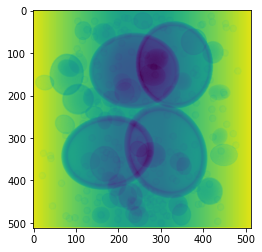

Compute projection: 100%|██████████| 1024/1024 [00:21<00:00, 46.78it/s]


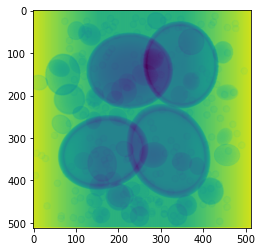

Compute projection: 100%|██████████| 1024/1024 [00:21<00:00, 47.93it/s]


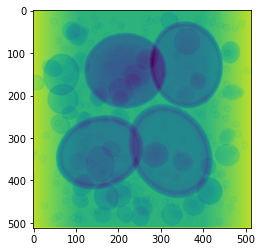

Compute projection: 100%|██████████| 1024/1024 [00:21<00:00, 47.59it/s]


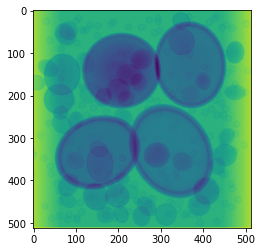

Compute projection: 100%|██████████| 1024/1024 [00:19<00:00, 51.22it/s]


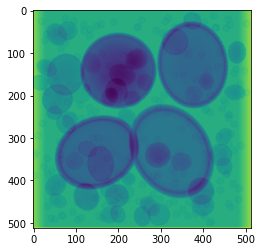

Compute projection: 100%|██████████| 1024/1024 [00:16<00:00, 62.58it/s]


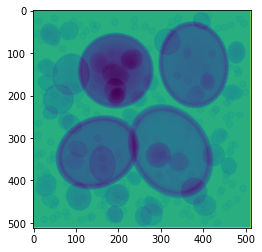

Compute projection: 100%|██████████| 1024/1024 [00:19<00:00, 53.72it/s]


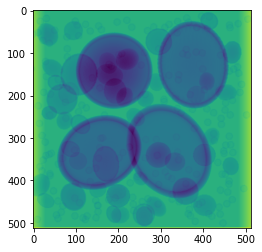

Compute projection: 100%|██████████| 1024/1024 [00:20<00:00, 49.84it/s]


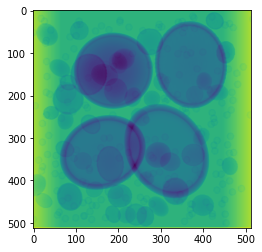

Compute projection: 100%|██████████| 1024/1024 [00:20<00:00, 50.68it/s]


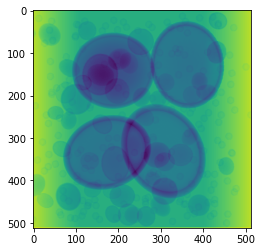

Compute projection: 100%|██████████| 1024/1024 [00:20<00:00, 49.06it/s]


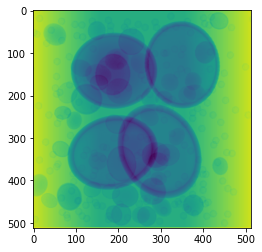

In [15]:
projections(volume)